In [16]:
# ! pip install optuna

In [17]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import joblib

# Set random seed for reproducibility
np.random.seed(42)

# Load the data
path_train = "./data/project_train.csv"
df = pd.read_csv(path_train, index_col=0)

# Separate features and target
X = df.drop("TARGET", axis=1)
y = df["TARGET"]

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
train_valid_splits = list(tscv.split(X))


def threshold_sum(y_true, y_pred, threshold):
    """
    Calculate the sum of targets for which the model predictions are above the threshold.
    """
    adjusted_target = np.where(y_pred > threshold, y_true, 0)
    return np.sum(adjusted_target)


def objective(trial):
    # Define the hyperparameters to optimize
    alpha = trial.suggest_float("alpha", 1e-5, 1.0, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0, 1)

    model = make_pipeline(StandardScaler(), ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42))

    mse_scores = []
    r2_scores = []
    custom_metric_values = []

    for train_index, valid_index in train_valid_splits:
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)

        mse = mean_squared_error(y_valid, y_pred)
        mse_scores.append(mse)

        r2 = r2_score(y_valid, y_pred)
        r2_scores.append(r2)

        custom_metric_value = threshold_sum(y_valid, y_pred, 0.0)
        custom_metric_values.append(custom_metric_value)

    mean_mse = np.mean(mse_scores)
    mean_r2 = np.mean(r2_scores)
    total_custom_metric_value = sum(custom_metric_values)

    trial.set_user_attr("mean_mse", mean_mse)
    trial.set_user_attr("mean_r2", mean_r2)
    trial.set_user_attr("sum_custom_metric", total_custom_metric_value)

    return mean_mse


# Create and run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=-1)

print("Best trial:")
trial = study.best_trial
print("  MSE: ", trial.value)
print("  R2: ", trial.user_attrs["mean_r2"])
print("  Custom Metric: ", trial.user_attrs["sum_custom_metric"])
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Save the study
joblib.dump(study, "./studies/linear_regression_optuna_study.pkl")

# Train final model with best parameters
best_model = make_pipeline(
    StandardScaler(), ElasticNet(alpha=trial.params["alpha"], l1_ratio=trial.params["l1_ratio"], random_state=42)
)
best_model.fit(X, y)

# Save the final model and scaler
joblib.dump(best_model, "./models/best_linear_regression.pkl")

print("\nOptimization complete. Study, best model, and scaler saved.")

# Feature importance
linear_model = best_model.named_steps["elasticnet"]
feature_importance = pd.DataFrame({"feature": X.columns, "importance": np.abs(linear_model.coef_)})
feature_importance = feature_importance.sort_values("importance", ascending=False)
print("\nTop 10 most important features:")
print(feature_importance.head(10))

# Prediction on the entire dataset
y_pred_full = best_model.predict(X)
full_mse = mean_squared_error(y, y_pred_full)
full_r2 = r2_score(y, y_pred_full)
full_custom_metric = threshold_sum(y, y_pred_full, 0.0)

print("\nFull dataset metrics:")
print(f"MSE: {full_mse}")
print(f"R2: {full_r2}")
print(f"Custom Metric: {full_custom_metric}")

[I 2024-10-20 17:42:31,185] A new study created in memory with name: no-name-c3317a38-66bb-4cd2-a4de-b28bf2b1df15
[I 2024-10-20 17:42:32,101] Trial 0 finished with value: 5.4770208328918684e-05 and parameters: {'alpha': 0.0005342050912689393, 'l1_ratio': 0.6487351909104669}. Best is trial 0 with value: 5.4770208328918684e-05.
[I 2024-10-20 17:42:33,172] Trial 1 finished with value: 5.4873147855755364e-05 and parameters: {'alpha': 0.2672904527439752, 'l1_ratio': 0.17349965902723097}. Best is trial 0 with value: 5.4770208328918684e-05.
[I 2024-10-20 17:42:34,130] Trial 3 finished with value: 5.4873147855755364e-05 and parameters: {'alpha': 0.3762207950787617, 'l1_ratio': 0.15437891204676046}. Best is trial 0 with value: 5.4770208328918684e-05.
[I 2024-10-20 17:42:34,733] Trial 2 finished with value: 5.4873147855755364e-05 and parameters: {'alpha': 0.10672507802495833, 'l1_ratio': 0.7965877972272334}. Best is trial 0 with value: 5.4770208328918684e-05.
[I 2024-10-20 17:42:35,055] Trial 4 

Best trial:
  MSE:  5.4600993596633036e-05
  R2:  0.005036420492716442
  Custom Metric:  15.7199981115
  Params: 
    alpha: 5.026603292826458e-05
    l1_ratio: 0.9446179831421068

Optimization complete. Study, best model, and scaler saved.

Top 10 most important features:
   feature  importance
4        4    0.000443
45      45    0.000155
9        9    0.000096
54      54    0.000054
59      59    0.000046
6        6    0.000026
8        8    0.000021
52      52    0.000012
5        5    0.000009
24      24    0.000001

Full dataset metrics:
MSE: 5.529289986701772e-05
R2: 0.005263429721859558
Custom Metric: 21.1868373425


<ipython-input-18-379ec88e6ebb>:15: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


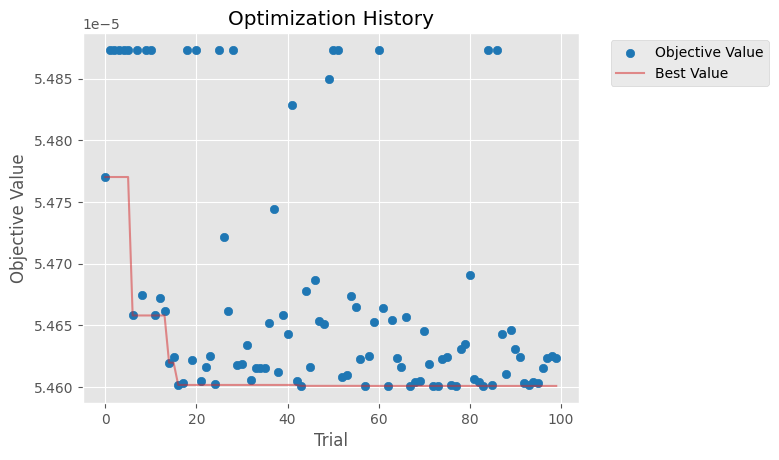

<ipython-input-18-379ec88e6ebb>:21: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


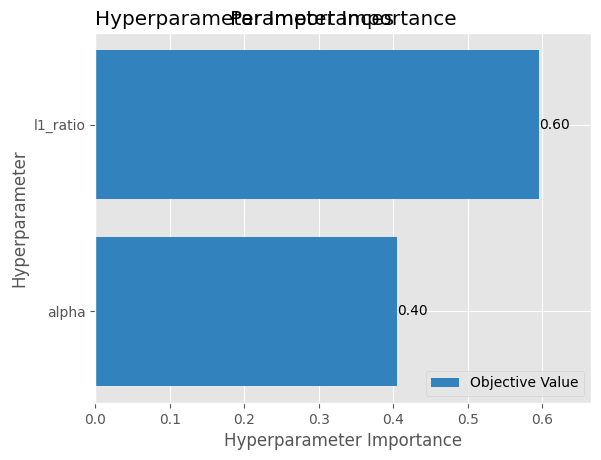

<ipython-input-18-379ec88e6ebb>:27: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)


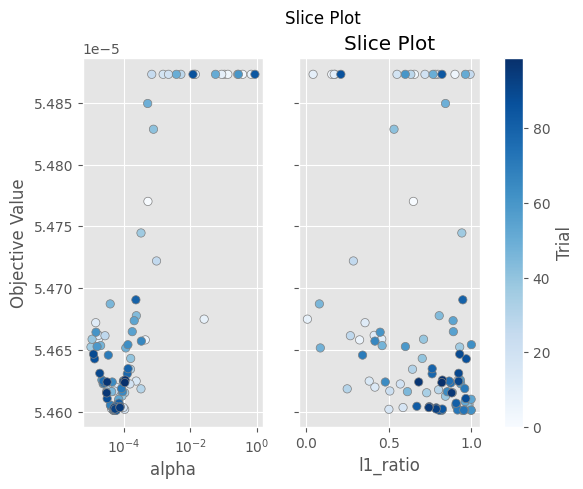

<ipython-input-18-379ec88e6ebb>:33: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study)
[W 2024-10-20 17:46:08,716] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


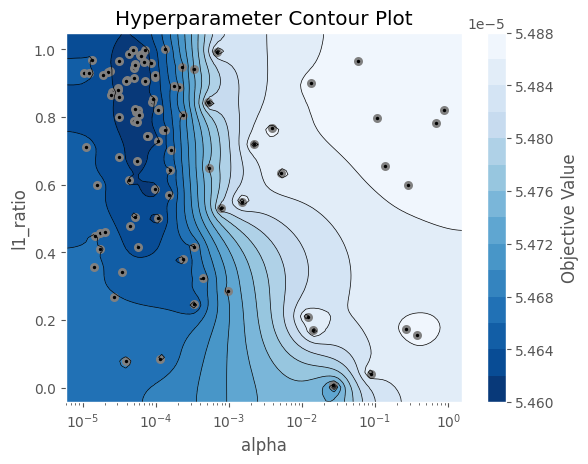

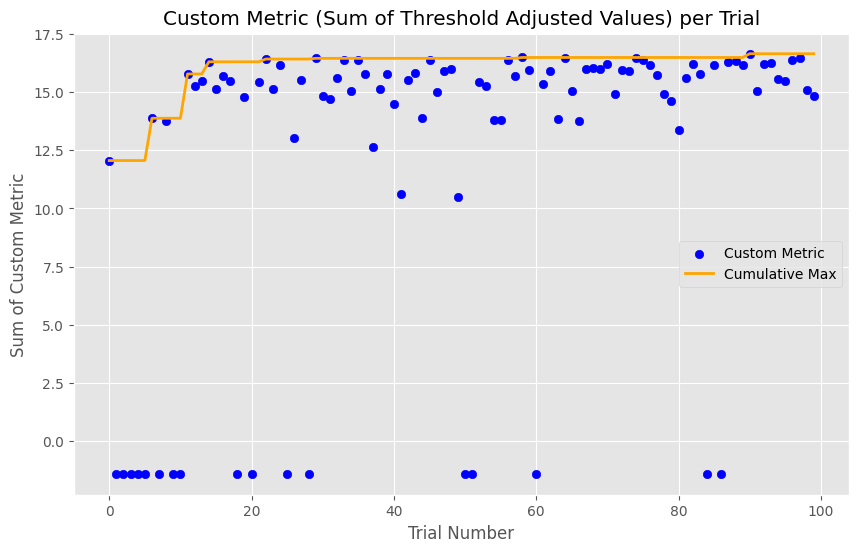

Mean Squared Error (MSE): 5.529289986701772e-05
Mean Absolute Error (MAE): 0.004422470752240195
R-squared (R2): 0.005263429721859558


In [18]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error
import joblib
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import optuna.visualization as vis
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Plot the optimization history
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optimization History")
plt.savefig("./plots/optimization_history.png")
plt.show()

# Plot parameter importance
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title("Parameter Importance")
plt.savefig("./plots/param_importance.png")
plt.show()

# Plot slice plot for detailed analysis
optuna.visualization.matplotlib.plot_slice(study)
plt.title("Slice Plot")
plt.savefig("./plots/slice_plot.png")
plt.show()

# Plot contour plot for interactions between parameters
optuna.visualization.matplotlib.plot_contour(study)
plt.title("Hyperparameter Contour Plot")
plt.savefig("./plots/contour_plot.png")
plt.show()

# Extract custom metric values from the study
custom_metric_values = []
for trial in study.trials:
    custom_metric_values.append(trial.user_attrs["sum_custom_metric"])

cumulative_max = np.maximum.accumulate(custom_metric_values)

# Create the scatter plot and the line for the cumulative max
plt.figure(figsize=(10, 6))
plt.scatter(range(len(custom_metric_values)), custom_metric_values, label="Custom Metric", color="blue")
plt.plot(cumulative_max, label="Cumulative Max", color="orange", linewidth=2)

plt.title("Custom Metric (Sum of Threshold Adjusted Values) per Trial")
plt.xlabel("Trial Number")
plt.ylabel("Sum of Custom Metric")
plt.grid(True)
plt.legend()
plt.show()


y_pred = best_model.predict(X)

# Calculate evaluation metrics
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Plot predicted vs actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y, y=y_pred, alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], color="red", linestyle="--")  # Line y=x
plt.title("Predicted vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.savefig("./plots/predicted_vs_actual.png")
plt.close()

# Plot residuals
residuals = y - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.savefig("./plots/residuals.png")
plt.close()

# Get feature importance from the linear model in the pipeline
linear_model = best_model.named_steps["elasticnet"]
importance = np.abs(linear_model.coef_)
features = X.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({"Feature": features, "Importance": importance}).sort_values(
    by="Importance", ascending=False
)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(20))
plt.title("Top 20 Feature Importance")
plt.savefig("./plots/feature_importance.png")
plt.close()

# Save best trial summary
best_trial = study.best_trial
with open("./studies/best_trial_summary.txt", "w") as f:
    f.write(f"Best Trial Value (Best MSE): {best_trial.value}\n")
    f.write(f"Best Parameters:\n")
    for key, value in best_trial.params.items():
        f.write(f"  {key}: {value}\n")

Custom Threshold Sum (Threshold = 0.0): 21.1868373425


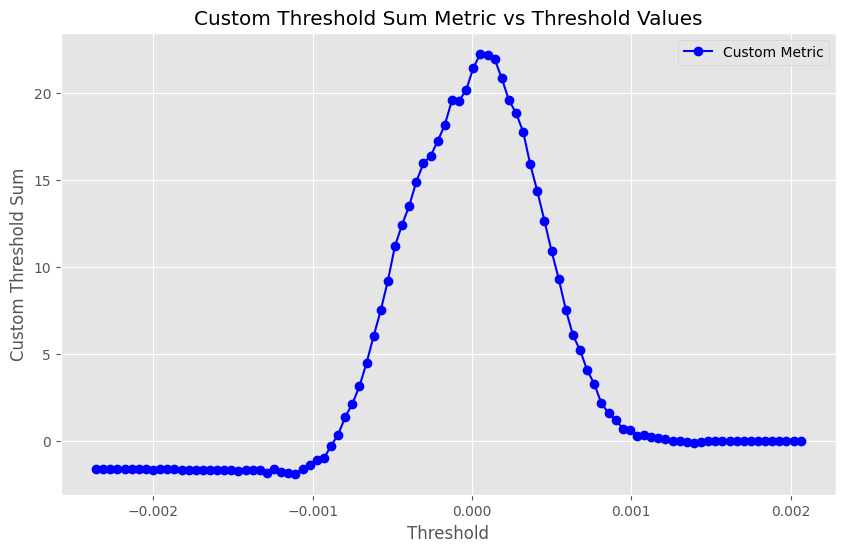

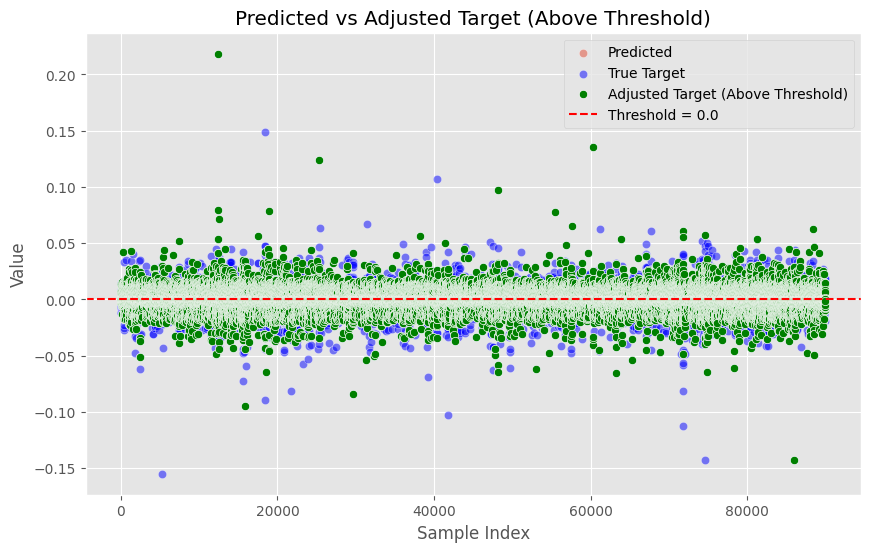

In [19]:
y_pred = best_model.predict(X)

threshold = 0.0
custom_metric_value = threshold_sum(y, y_pred, threshold)
print(f"Custom Threshold Sum (Threshold = {threshold}): {custom_metric_value}")

threshold_values = np.linspace(np.min(y_pred), np.max(y_pred), 100)
custom_metric_values = []

for threshold in threshold_values:
    custom_metric_value = threshold_sum(y, y_pred, threshold)
    custom_metric_values.append(custom_metric_value)

# Plot the custom metric vs threshold
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, custom_metric_values, marker="o", color="b", label="Custom Metric")
plt.title("Custom Threshold Sum Metric vs Threshold Values")
plt.xlabel("Threshold")
plt.ylabel("Custom Threshold Sum")
plt.grid(True)
plt.legend()
plt.savefig("./plots/custom_metric_vs_threshold.png")
plt.show()


# Plot for a selected threshold
threshold = 0.0
adjusted_y = np.where(y_pred > threshold, y, 0)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(y)), y=y_pred, label="Predicted", alpha=0.5)
sns.scatterplot(x=range(len(y)), y=y, label="True Target", color="blue", alpha=0.5)
sns.scatterplot(x=range(len(y)), y=adjusted_y, label="Adjusted Target (Above Threshold)", color="green")
plt.axhline(threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
plt.title("Predicted vs Adjusted Target (Above Threshold)")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.legend()
plt.savefig("./plots/predicted_vs_adjusted_threshold.png")
plt.show()